femのサロゲートモデル学習用

In [108]:
# --- Colab用セットアップセル ---
# 1. 必要なライブラリのインストール
# PyVistaのバックエンド(xvfb)もインストールします
!apt-get install -y xvfb
!pip install torch numpy pyvista tqdm pandas

# 2. データセットのダウンロードと解凍
import os
import zipfile

# すでに解凍済みでなければダウンロード
if not os.path.exists('vtu'):
    print("Downloading data...")
    # 元のコードにあったURLを使用
    DATA_URL = "https://github.com/WOCae/R211/raw/main/vtu.zip" 
    !wget -O data_files.zip "{DATA_URL}"
    
    print("Unzipping...")
    with zipfile.ZipFile('data_files.zip', 'r') as zip_ref:
        zip_ref.extractall('vtu')
    print("Data ready.")
else:
    print("Data already exists.")

# 3. PyVistaの仮想ディスプレイ設定（これがないとColabで動きません）
import pyvista as pv
# 仮想ディスプレイを開始
pv.start_xvfb()

print("Setup Complete! You can run the next cells.")

'apt-get' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


Data already exists.


c:\work\HP4\deepxde\.venv\lib\site-packages\pyvista\plotting\utilities\xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


OSError: `start_xvfb` is only supported on Linux

In [ ]:
import os
import glob
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
from torch.utils.data import TensorDataset, DataLoader
from scipy.interpolate import NearestNDInterpolator
import pyvista as pv
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 設定の一括管理 ---
class Config:
    # 3Dグリッド解像度
    nx, ny, nz = 24, 24, 24

    # 物理座標の範囲
    x_range = (0.0, 10.0)
    y_range = (0.0, 10.0)
    z_range = (0.0, 100.0)

    # デバイス設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- 正規化係数の一元管理 ---
    # ここで値を変更すれば、学習・推論・可視化すべてに反映されます
    NORM_LOAD   = 10000.0  # 荷重正規化用
    NORM_DISP   = 1e-4     # 変位正規化用
    NORM_STRESS = 1e7      # 応力正規化用

    # スケール辞書（正規化係数を参照）
    scales = {
        'ux': NORM_DISP, 'uy': NORM_DISP, 'uz': NORM_DISP,
        'disp': NORM_DISP,
        'mises': NORM_STRESS,
        'stress': NORM_STRESS
    }

print(f"Using device: {Config.device}")
print(f"Grid size: {Config.nx}x{Config.ny}x{Config.nz}")

Using device: cpu
Grid size: 24x24x24


In [ ]:
def load_case(vtu_path):
    """VTUファイルからデータを読み込む"""
    mesh = pv.read(vtu_path)
    pts = mesh.points.astype(np.float32)
    disp = mesh.point_data["Displacement"].astype(np.float32)
    mises = mesh.point_data["von Mises Stress"].astype(np.float32)
    return pts, disp, mises

def interpolate_to_grid_3d(pts, disp, mises):
    """点群データを3Dグリッドへ補間（Nearest近傍法）"""
    points = pts[:, :3]
    
    # ターゲットグリッド作成
    gx = np.linspace(Config.x_range[0], Config.x_range[1], Config.nx, dtype=np.float32)
    gy = np.linspace(Config.y_range[0], Config.y_range[1], Config.ny, dtype=np.float32)
    gz = np.linspace(Config.z_range[0], Config.z_range[1], Config.nz, dtype=np.float32)
    grid_x, grid_y, grid_z = np.meshgrid(gx, gy, gz, indexing='ij')
    target_points = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=-1)

    # 補間実行
    values = np.column_stack([disp, mises])
    interp = NearestNDInterpolator(points, values)
    interpolated = interp(target_points)
    
    # グリッド形状にリシェイプ (nx, ny, nz, 4)
    result = interpolated.reshape(Config.nx, Config.ny, Config.nz, 4)
    return result[..., 0], result[..., 1], result[..., 2], result[..., 3]

def create_geometry_masks(nx, ny, nz):
    """
    【重要】形状・境界条件マスクを一括生成する関数
    学習データ作成時と推論時の両方でここを呼び出すことで、条件不一致を防ぐ。
    """
    # 1. 形状マスク (Geometry): 全体が存在(1.0)
    geo_mask = np.ones((nx, ny, nz), dtype=np.float32)

    # 2. 固定境界マスク (BC Fixed): Z=0 (index 0) の面
    fix_mask = np.zeros_like(geo_mask)
    fix_mask[:, :, 0] = 1.0

    # 3. 荷重境界マスク (BC Load): Z=max (index -1) の面
    load_mask = np.zeros_like(geo_mask)
    load_mask[:, :, -1] = 1.0
    
    return geo_mask, fix_mask, load_mask

def make_inp_out(pts, disp, mises, load_norm_value):
    """入力テンソルと出力テンソルのペアを作成"""
    # 1. 物理量の補間
    ux, uy, uz, ms = interpolate_to_grid_3d(pts, disp, mises)

    # 2. マスクの生成（共通関数を利用）
    geo_mask, fix_mask, load_mask = create_geometry_masks(Config.nx, Config.ny, Config.nz)

    # 3. 荷重値チャンネル (全体に正規化荷重値を埋める)
    val_channel = np.full_like(geo_mask, load_norm_value, dtype=np.float32)

    # --- Input: (4, nx, ny, nz) ---
    # [形状, 固定位置, 荷重点位置, 荷重値]
    inp = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=0)

    # --- Output: (4, nx, ny, nz) ---
    # 正規化してスタック
    out = np.stack([
        ux / Config.scales['disp'],
        uy / Config.scales['disp'],
        uz / Config.scales['disp'],
        ms / Config.scales['stress']
    ], axis=0)

    return inp, out

In [ ]:
# ファイル一覧取得
vtu_files = sorted(glob.glob("vtu/**/*.vtu", recursive=True))

inputs = []
outputs = []
data_summary = []  # 統計情報用リスト

print("Processing VTU files (Loading + Statistics)...")

# --- 統合ループ: データ作成と統計収集を同時に実施 ---
for vtu_path in tqdm(vtu_files):
    # ファイル名から荷重値パース (例: "2_-2000.vtu" -> -2000)
    stem = os.path.splitext(os.path.basename(vtu_path))[0]
    try:
        _, load_str = stem.split("_", 1)
        load_val = float(load_str)
    except:
        continue

    # 1. 重い処理（ファイル読み込み）はここで1回だけ
    pts, disp, mises = load_case(vtu_path)

    # --- A. 統計情報の記録 ---
    data_summary.append({
        "File Name": stem,
        "Load [N]": load_val,
        "Uz_Min [m]": np.min(disp[:, 2]),
        "Uz_Max [m]": np.max(disp[:, 2]),
        "Max_Mises [Pa]": np.max(mises)
    })

    # --- B. 学習データの作成 ---
    load_norm_val = load_val / Config.NORM_LOAD
    inp, out = make_inp_out(pts, disp, mises, load_norm_val)

    # (C, D, H, W) -> (D, H, W, C) に変換 (FNOモデルの入力形式に合わせる)
    inputs.append(np.moveaxis(inp, 0, -1).astype(np.float32))
    outputs.append(np.moveaxis(out, 0, -1).astype(np.float32))

# --- 結果の確認 ---
# 1. 統計データの表示
df_train = pd.DataFrame(data_summary)
print("\n--- Data Summary (First 5 rows) ---")
display(df_train.head())

# 2. Tensor化
X_all = np.stack(inputs, axis=0) # (N, nx, ny, nz, 4)
Y_all = np.stack(outputs, axis=0)

X_torch = torch.from_numpy(X_all).float()
Y_torch = torch.from_numpy(Y_all).float()

print(f"\nTensor Shapes:")
print(f" Input:  {X_torch.shape}")
print(f" Output: {Y_torch.shape}")

# Dataset & Loader
dataset = TensorDataset(X_torch, Y_torch)
loader = DataLoader(dataset, batch_size=4, shuffle=True) # batch_sizeはお好みで

Processing VTU files (Loading + Statistics)...


100%|██████████| 6/6 [00:00<00:00, 100.32it/s]


--- Data Summary (First 5 rows) ---


,File Name,Load [N],Uz_Min [m],Uz_Max [m],Max_Mises [Pa]
0,2_2000,2000.0,0.0,0.000010,20000900.0
1,3_3000,3000.0,0.0,0.000014,30002300.0
2,4_4000,4000.0,0.0,0.000019,40004200.0
3,5_5000,5000.0,0.0,0.000024,50006600.0
4,6_6000,6000.0,0.0,0.000029,60009700.0



Tensor Shapes:
 Input:  torch.Size([6, 24, 24, 24, 4])
 Output: torch.Size([6, 24, 24, 24, 4])


In [ ]:
# --- モデル定義 (SpectralConv3d & FNO3d) ---
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_x, modes_y, modes_z):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.modes_z = modes_z

        scale = 1 / (in_channels * out_channels)
        self.weight_real = nn.Parameter(scale * torch.randn(in_channels, out_channels, modes_x, modes_y, modes_z))
        self.weight_imag = nn.Parameter(scale * torch.randn(in_channels, out_channels, modes_x, modes_y, modes_z))

    def compl_mul3d(self, input, weight_real, weight_imag):
        real = torch.einsum("bixyz,ioxyz->boxyz", input.real, weight_real) - \
               torch.einsum("bixyz,ioxyz->boxyz", input.imag, weight_imag)
        imag = torch.einsum("bixyz,ioxyz->boxyz", input.real, weight_imag) + \
               torch.einsum("bixyz,ioxyz->boxyz", input.imag, weight_real)
        return torch.complex(real, imag)

    def forward(self, x):
        batchsize, channels, nx, ny, nz = x.shape
        x_ft = fft.rfftn(x, dim=[-3, -2, -1], norm="ortho")
        out_ft = torch.zeros(batchsize, self.out_channels, x_ft.size(-3), x_ft.size(-2), x_ft.size(-1),
                             dtype=torch.cfloat, device=x.device)
        
        kx, ky, kz = self.modes_x, self.modes_y, self.modes_z
        out_ft[:, :, :kx, :ky, :kz] = self.compl_mul3d(x_ft[:, :, :kx, :ky, :kz], self.weight_real, self.weight_imag)
        
        return fft.irfftn(out_ft, s=(nx, ny, nz), dim=[-3, -2, -1], norm="ortho")

class FNO3d(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, width=32, modes=8):
        super().__init__()
        self.width = width
        self.fc_in = nn.Linear(in_channels, width)
        self.convs = nn.ModuleList([SpectralConv3d(width, width, modes, modes, modes) for _ in range(4)])
        self.ws = nn.ModuleList([nn.Conv3d(width, width, 1) for _ in range(4)])
        self.fc_out1 = nn.Linear(width, 128)
        self.fc_out2 = nn.Linear(128, out_channels)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc_in(x)
        x = x.permute(0, 4, 1, 2, 3)
        for conv, w in zip(self.convs, self.ws):
            x = self.act(conv(x) + w(x))
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc_out2(self.act(self.fc_out1(x)))
        return x

# --- 学習実行 ---
model = FNO3d(in_channels=4, out_channels=4, width=32, modes=8).to(Config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("Start Training...")
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(Config.device), yb.to(Config.device)
        
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d}/50, Loss: {total_loss/len(loader):.6e}")

Start Training...
Epoch   5/50, Loss: 4.760209e+00
Epoch  10/50, Loss: 5.179163e+00
Epoch  15/50, Loss: 1.246108e+00
Epoch  20/50, Loss: 7.941898e-01
Epoch  25/50, Loss: 8.376616e-01
Epoch  30/50, Loss: 4.791544e-01
Epoch  35/50, Loss: 4.669682e-01
Epoch  40/50, Loss: 4.748603e-01
Epoch  45/50, Loss: 4.882337e-01
Epoch  50/50, Loss: 4.342234e-01


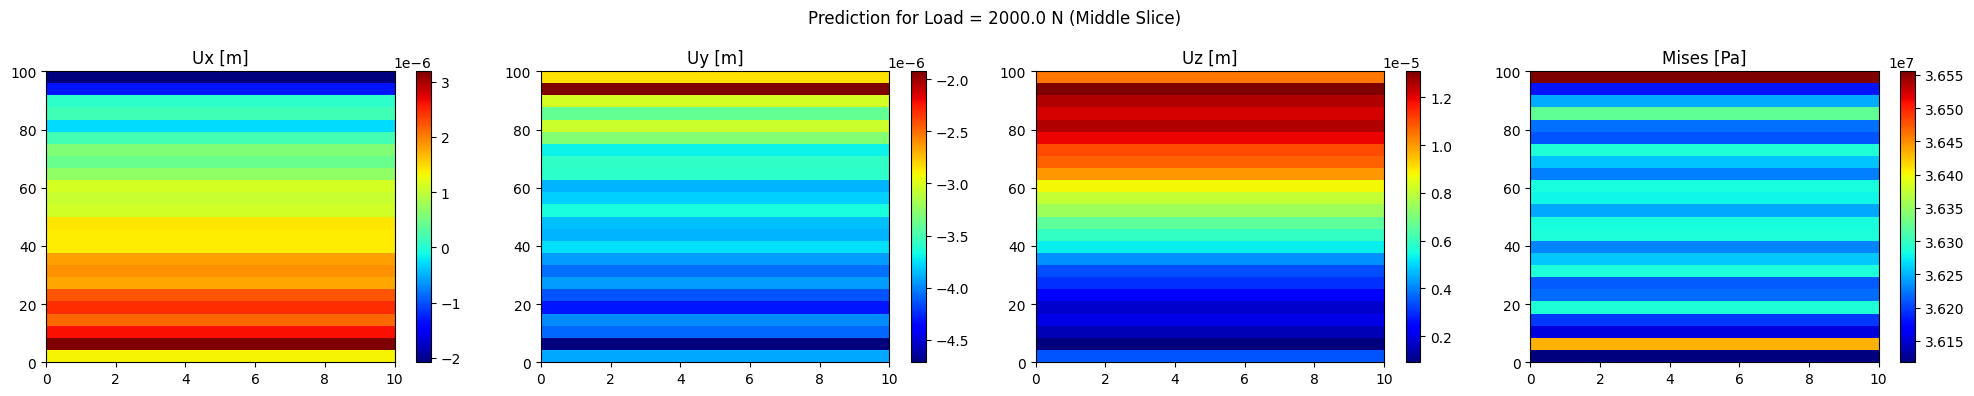

Max Uz at tip: 1.309e-05 m
Max Stress:    36.56 MPa


In [ ]:
# --- 任意荷重での推論 ---

# 1. 共通関数でマスク生成（手動定義不要！）
geo_mask, fix_mask, load_mask = create_geometry_masks(Config.nx, Config.ny, Config.nz)

# 2. 任意の荷重値を設定
any_load_N = 2000.0  # テストしたい荷重値 [N]
load_norm_val = any_load_N / Config.NORM_LOAD
val_channel = np.full_like(geo_mask, load_norm_val, dtype=np.float32)

# 3. 入力テンソル作成
inp_np = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=-1) # (nx, ny, nz, 4)
inp_torch = torch.from_numpy(inp_np).unsqueeze(0).to(Config.device)      # (1, nx, ny, nz, 4)

# 4. 推論実行
model.eval()
with torch.no_grad():
    pred = model(inp_torch)

# 5. 結果取り出し & 物理量復元
pred_np = pred.squeeze(0).cpu().numpy()
ux = pred_np[..., 0] * Config.scales['disp']
uy = pred_np[..., 1] * Config.scales['disp']
uz = pred_np[..., 2] * Config.scales['disp']
ms = pred_np[..., 3] * Config.scales['stress']

# --- 以下、可視化コード ---
y_mid = Config.ny // 2
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle(f"Prediction for Load = {any_load_N} N (Middle Slice)")

extent = [Config.x_range[0], Config.x_range[1], Config.z_range[0], Config.z_range[1]]
props = [ux, uy, uz, ms]
titles = ["Ux [m]", "Uy [m]", "Uz [m]", "Mises [Pa]"]

for i, (data, title) in enumerate(zip(props, titles)):
    # Y中央スライス (nx, nz) を表示 ※転置して (z, x) 表示にするかはお好みで
    im = axes[i].imshow(data[:, y_mid, :].T, origin='lower', cmap='jet', 
                        extent=extent, aspect='auto')
    axes[i].set_title(title)
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

# 荷重点の値チェック
print(f"Max Uz at tip: {np.max(uz):.3e} m")
print(f"Max Stress:    {np.max(ms)/1e6:.2f} MPa")